In [1]:
! pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

**创建数据**

In [3]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
# 地物类别
class_num = 16
#X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/PaviaU.mat')['paviaU']
#y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/PaviaU_gt.mat')['paviaU_gt']
X = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.9
# 每个像素周围提取 patch 的尺寸
patch_size = 11
# 使用 PCA 降维，得到主成分的数量
pca_components = 100

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)



# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 3, 1, 2)
Xtest  = Xtest.transpose(0, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 100)

... ... create data cubes ... ...
Data cube X shape:  (10249, 11, 11, 100)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 11, 11, 100)
Xtest  shape:  (9225, 11, 11, 100)
after transpose: Xtrain shape:  (1024, 100, 11, 11)
after transpose: Xtest  shape:  (9225, 100, 11, 11)


In [5]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=32, shuffle=False, num_workers=2)

**创建模型**

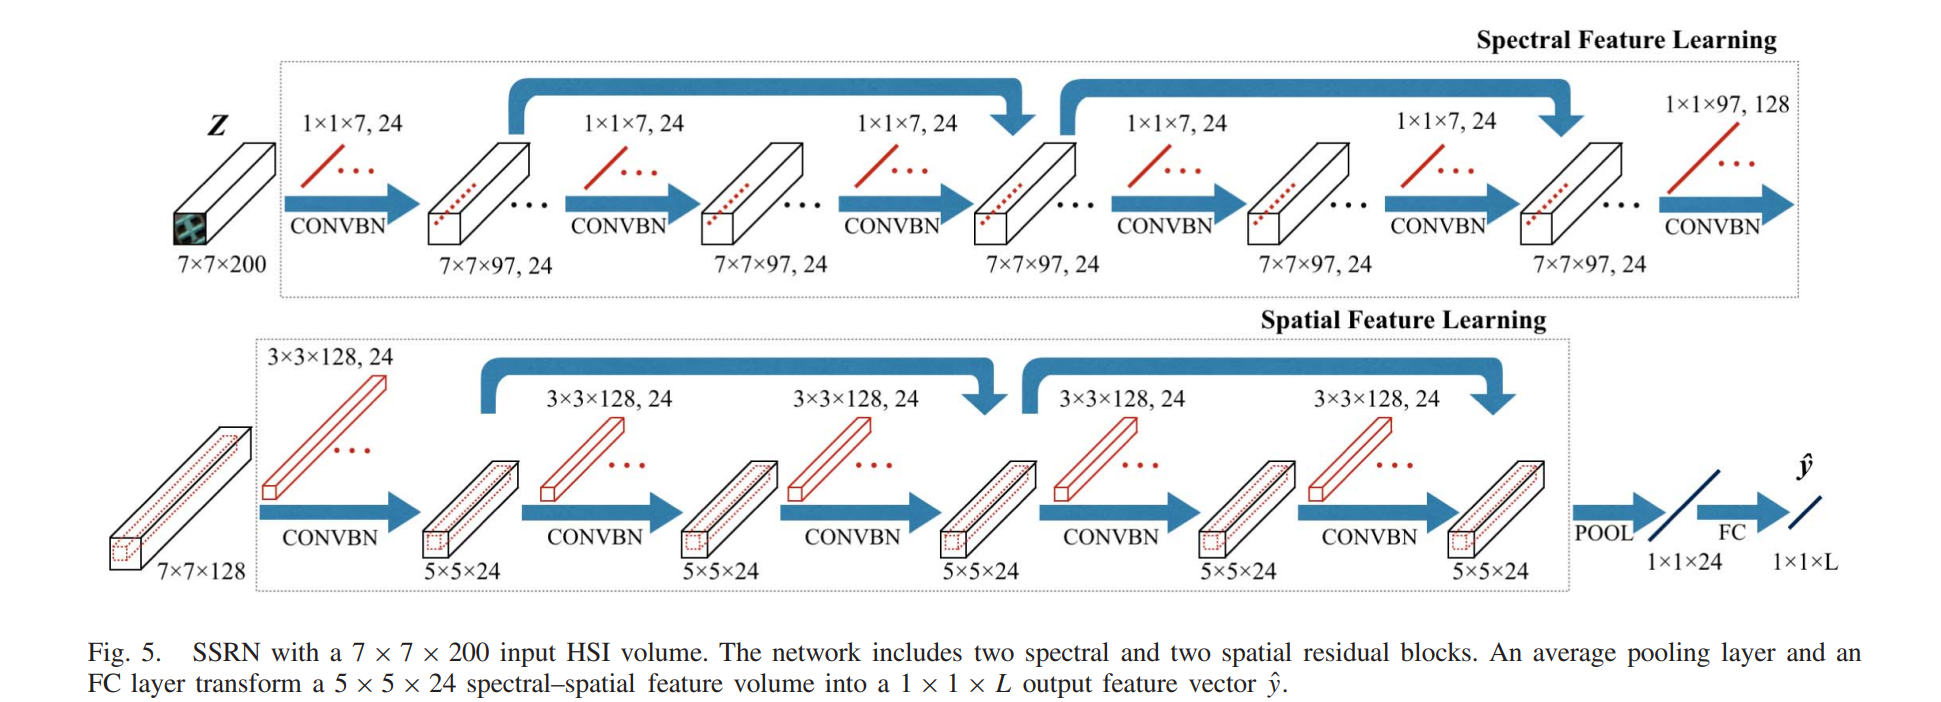

In [6]:
class SSRN(nn.Module):
  def __init__(self):
    super(SSRN,self).__init__()
    self.FE1 = nn.Sequential(
        nn.Conv3d(in_channels=1,out_channels=24,kernel_size=(7,1,1),stride=(2,1,1)),
        nn.BatchNorm3d(24),
    )
    self.spe_conv1 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.spe_conv2 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.CF = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=128,kernel_size=(47,1,1),stride=(1,1,1)),
        nn.BatchNorm3d(128),
    )
    self.FE2 = nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=24,kernel_size=(3,3),stride=(1,1)),
        nn.BatchNorm2d(24),
    )
    self.spa_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.3),
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.Dropout2d(p=0.3),
    )
    self.avgpool = nn.AvgPool2d(kernel_size=5)
    self.classification = nn.Linear(24,16)
  def forward(self,x):
    #print("输入数据的shape为：",x.shape)
    x = torch.unsqueeze(x,dim=1)
    #print("输入数据扩展后的shape为：",x.shape)
    FE1 = self.FE1(x)
    #print("FE1运行后的shape为：",FE1.shape)
    spe_conv1 = self.spe_conv1(FE1)
    spe_conv1_res = spe_conv1+FE1
    spe_conv2 = self.spe_conv2(spe_conv1_res)
    spe_conv2_res = spe_conv2+spe_conv1_res
    #print("spe_conv2_res的shape为：:",spe_conv2_res.shape)
    CF = self.CF(spe_conv2_res)
    #print("CF运行后的shape为：:",CF.shape)
    CF = torch.squeeze(CF,dim=2)
    #print("CF压缩后的shape为:",CF.shape)
    FE2 = self.FE2(CF)
    #print("FE2运行后的shape为：",FE2.shape)
    spa_conv1 = self.spa_conv1(FE2)
    spa_conv1_res = spa_conv1+FE2
    #print("spa_conv1_res的shape为：",spa_conv1_res.shape)
    avg = self.avgpool(spa_conv1_res)
    #print("spa_conv1_res在最大池化后的avg的shape为:",avg.shape)
    avg = torch.squeeze(avg)
    #print("avg在压缩后的shape为：",avg.shape)
    out = self.classification(avg)
    return out

In [ ]:
class SSRN_1(nn.Module):
  def __init__(self):
    super(SSRN_1,self).__init__()
    self.FE1 = nn.Sequential(
        nn.Conv3d(in_channels=1,out_channels=24,kernel_size=(7,1,1),stride=(2,1,1)),
        nn.BatchNorm3d(24),
    )
    self.spe_conv1 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.spe_conv2 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.CF = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=128,kernel_size=(97,1,1),stride=(1,1,1)),
        nn.BatchNorm3d(128),
    )
    self.FE2 = nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=24,kernel_size=(3,3),stride=(1,1)),
        nn.BatchNorm2d(24),
    )
    self.spa_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.3),
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.Dropout2d(p=0.3),
    )
    self.avgpool = nn.AvgPool2d(kernel_size=5)
    self.classification = nn.Linear(600,16)
  def forward(self,x):
    #print("输入数据的shape为：",x.shape)
    x = torch.unsqueeze(x,dim=1)
    #print("输入数据扩展后的shape为：",x.shape)
    FE1 = self.FE1(x)
    #print("FE1运行后的shape为：",FE1.shape)
    spe_conv1 = self.spe_conv1(FE1)
    spe_conv1_res = spe_conv1+FE1
    spe_conv2 = self.spe_conv2(spe_conv1_res)
    spe_conv2_res = spe_conv2+spe_conv1_res
    #print("spe_conv2_res的shape为：:",spe_conv2_res.shape)
    CF = self.CF(spe_conv2_res)
    #print("CF运行后的shape为：:",CF.shape)
    CF = torch.squeeze(CF,dim=2)
    #print("CF压缩后的shape为:",CF.shape)
    FE2 = self.FE2(CF)
    #print("FE2运行后的shape为：",FE2.shape)
    spa_conv1 = self.spa_conv1(FE2)
    spa_conv1_res = spa_conv1+FE2
    #print("spa_conv1_res的shape为：",spa_conv1_res.shape)
    x = spa_conv1_res
    x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
    #print("spa_conv1_res在view后的shape为:",x.shape)
    out = self.classification(x)
    return out

In [11]:
x = torch.randn(566, 100, 11, 11)
net = SSRN()
y = net(x)
print(y.shape)

输入数据的shape为： torch.Size([566, 100, 11, 11])
输入数据扩展后的shape为： torch.Size([566, 1, 100, 11, 11])
FE1运行后的shape为： torch.Size([566, 24, 47, 11, 11])
spe_conv2_res的shape为：: torch.Size([566, 24, 47, 11, 11])
CF运行后的shape为：: torch.Size([566, 128, 1, 11, 11])
CF压缩后的shape为: torch.Size([566, 128, 11, 11])
FE2运行后的shape为： torch.Size([566, 24, 9, 9])
spa_conv1_res的shape为： torch.Size([566, 24, 9, 9])
spa_conv1_res在最大池化后的avg的shape为: torch.Size([566, 24, 1, 1])
avg在压缩后的shape为： torch.Size([566, 24])
torch.Size([566, 16])


**训练与测试**

In [7]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [8]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [9]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = SSRN().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 48.0989]   [current loss: 1.1379]  [current acc: 0.8232]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 35.7131]   [current loss: 0.6371]  [current acc: 0.9081]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 3]   [loss avg: 28.8102]   [current loss: 0.5014]  [current acc: 0.9238]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 4]   [loss avg: 24.3788]   [current loss: 0.3969]  [current acc: 0.9373]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 5]   [loss avg: 21.1242]   [current loss: 0.2974]  [current acc: 0.9494]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 6]   [loss avg: 18.8000]   [current loss: 0.3925]  [current acc: 0.9369]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 7]   [loss avg: 17.0138]   [current loss: 0.1460]  [current acc: 0.9579]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 8]   [loss avg: 15.5805]   [current loss: 0.2154]  [current acc: 0.9515]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 9]   [loss avg: 14.2693]   [current loss: 0.1070]  [current acc: 0.9754]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 10]   [loss avg: 13.0950]   [current loss: 0.0908]  [current acc: 0.9746]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 11]   [loss avg: 12.0873]   [current loss: 0.1190]  [current acc: 0.9800]
[Epoch: 12]   [loss avg: 11.4009]   [current loss: 0.0799]  [current acc: 0.9638]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 13]   [loss avg: 10.7341]   [current loss: 0.0239]  [current acc: 0.9728]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 14]   [loss avg: 10.1094]   [current loss: 0.0193]  [current acc: 0.9796]
[Epoch: 15]   [loss avg: 9.5502]   [current loss: 0.0248]  [current acc: 0.9795]
[Epoch: 16]   [loss avg: 9.0541]   [current loss: 0.0776]  [current acc: 0.9756]
[Epoch: 17]   [loss avg: 8.6132]   [current loss: 0.0374]  [current acc: 0.9786]
[Epoch: 18]   [loss avg: 8.2053]   [current loss: 0.0859]  [current acc: 0.9816]
[Epoch: 19]   [loss avg: 7.8311]   [current loss: 0.0121]  [current acc: 0.9791]
[Epoch: 20]   [loss avg: 7.4900]   [current loss: 0.0094]  [current acc: 0.9809]
[Epoch: 21]   [loss avg: 7.1675]   [current loss: 0.0303]  [current acc: 0.9808]
[Epoch: 22]   [loss avg: 6.8670]   [current loss: 0.0175]  [current acc: 0.9833]
[Epoch: 23]   [loss avg: 6.5881]   [current loss: 0.0417]  [current acc: 0.9839]
[Epoch: 24]   [loss avg: 6.3462]   [current loss: 0.0083]  [current acc: 0.9826]
[Epoch: 25]   [loss avg: 6.1132]   [current loss: 0.0195]  [current acc: 0.9846]
[Epoch: 26]   [loss avg: 5.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_plot(data,plot_name,x_name,y_name):
  plt.title(plot_name)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.plot(data)

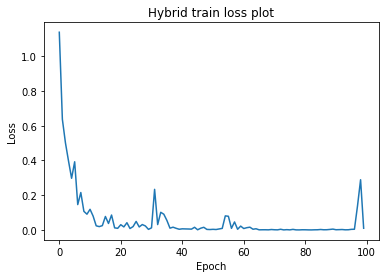

In [11]:
show_plot(current_loss_his,'Hybrid train loss plot','Epoch','Loss')
#show_plot(current_loss_his1,'Hybrid train loss plot','Epoch','Loss')

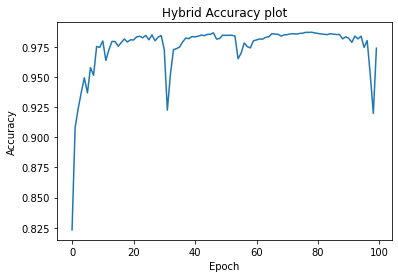

In [12]:
show_plot(current_Acc_his,'Hybrid Accuracy plot','Epoch','Accuracy')
#show_plot(current_Acc_his1,'Hybrid Accuracy plot','Epoch','Accuracy')

In [13]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        41
         1.0     0.9945    0.9798    0.9871      1285
         2.0     0.9712    0.9946    0.9828       747
         3.0     0.9857    0.9718    0.9787       213
         4.0     0.9885    0.9908    0.9897       435
         5.0     0.9894    0.9954    0.9924       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    1.0000    1.0000       430
         8.0     1.0000    0.8889    0.9412        18
         9.0     0.9863    0.9840    0.9851       875
        10.0     0.9874    0.9900    0.9887      2210
        11.0     0.9904    0.9625    0.9763       534
        12.0     0.9890    0.9676    0.9781       185
        13.0     0.9879    1.0000    0.9939      1139
        14.0     0.9798    0.9769    0.9784       347
        15.0     0.9195    0.9524    0.9357        84

    accuracy                         0.9871      9225
   macro avg     0.9856   